<a href="https://colab.research.google.com/github/anhvt00/PIPR/blob/master/models/FSNN_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [3]:
!pip install lightgbm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef,accuracy_score, precision_score,recall_score
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
import lightgbm as lgb
import time

### Sample seq

In [4]:
seq = "MKFVYKEEHPFEKRRSEGEKIRKKYPDRVPVIVEKAPKARIGDLDKKKYLVPSDLTVGQFYFLIRKRIHLRAEDALFFFVNNVIPPTSATMGQLYQEHHEEDFFLYIAYSDESVYGL"

### Conjoint Triad

In [5]:
# # https://sci-hub.se/https://doi.org/10.3390/ijms18112373
# # After that, the conjoint triad method is introduced to extract the sequence information, which includes the properties of one amino acid and its vicinal amino acids and regards any 
# # three continuous amino acids as a unit. Firstly, they replaced each amino acid in the protein sequence by the index depending on its grouping. For instance, protein sequence
# # “VCCPPVCVVCPPVCVPVPPCCV” is replaced by 0112201001220102022110. Then, binary space (V, F) stands for a protein sequence. Here, V is the vector sp… acids grouped into seven classes, the size V 
# # should be 7 × 7 × 7; therefore, i = 0, 1, · · · , 342. The detailed definition and description is shown in Figure 4. Clearly, each protein has a corresponding F vector. Nevertheless, the value
# # of fi relates to the length of amino acid sequence. A longer amino acid sequence generally have a larger value of fi, which complicates the comparison between two heterogeneous proteins. 
# # As such they employed the normalization to solve this problem as follows: di = (fi - min fi) / max fi for i = 1 to 343, where the value of di is normalized in the range [0, 1]. fi is the
# # frequency of conjoint triad unit vi appearing in the protein sequence. Finally, they connected the vector spaces of two proteins to present the interaction features. Thus, a 686-dimensional 
# # vector (343 for each protein) is generated for each pair of proteins.

# # original paper: https://www.pnas.org/content/104/11/4337 (shen et al., 2007)
# ct_encoding = {
#     "A": 0,
#     "G": 0,
#     "V": 0,
#     "C": 1,
#     "F": 2,
#     "I": 2,
#     "L": 2,
#     "P": 2,
#     "M": 3,
#     "S": 3,
#     "T": 3,
#     "Y": 3,
#     "H": 4,
#     "N": 4,
#     "Q": 4,
#     "W": 4,
#     "K": 5,
#     "R": 5,
#     "D": 6,
#     "E": 6,
# }

# f = open('encode_ct.txt', 'w')
# for aa, value in ct_encoding.items():
#   f.write(str(aa)+'\t'+str(value)+'\n')

# f.close()

In [6]:
"""Implementation of CT coding method
"""

__all__ = ['ct_code_of']

# AAC: Classification of amino acids.
AAC = {
    '1': ['A', 'G', 'V'],
    '2': ['I', 'L', 'F', 'P'],
    '3': ['Y', 'M', 'T', 'S'],
    '4': ['H', 'N', 'Q', 'W'],
    '5': ['R', 'K'],
    '6': ['D', 'E'],
    '7': ['C']
}

# AAC_R: Reverse of AAC.
AAC_R = {}
for C, AAS in AAC.items():
    for AA in AAS:
        AAC_R[AA] = C

def classification_of(AA):
    """Get classification of amino acids."""
    return AAC_R[AA]

def classification_sequence_of(PS):
    """Make classification sequence from protein sequence."""
    CS = ''
    for I, CH in enumerate(PS):
        CS = CS + classification_of(CH)
    return CS

def ct_code_of(PS):
    """Get CT Code of protein sequence."""
    CT_Code = [0]*343
    CS = classification_sequence_of(PS)
    for I in range(len(CS)-2):
        SubCS = CS[I:I+3]
        CT_Code_Index = int(SubCS[0]) + (int(SubCS[1])-1)*7 + (int(SubCS[2])-1)*7*7
        CT_Code[CT_Code_Index-1] = CT_Code[CT_Code_Index-1] + 1
    SUM = sum(CT_Code)
    CT_Code = [N*1.0/SUM for N in CT_Code]
    # Normalizing CT_Code
    # MIN_CODE = min(CT_Code)
    # MAX_CODE = max(CT_Code)
    # CT_Code = [(N-MIN_CODE)*1.0/(MAX_CODE-MIN_CODE) for N in CT_Code]
    return CT_Code

if __name__=="__main__":
    for I, Frequency in enumerate(ct_code_of('MREIVHIQAG')):
        if Frequency>0 :
            print(I+1, Frequency)

4 0.125
13 0.125
23 0.125
71 0.125
89 0.125
149 0.125
158 0.125
276 0.125


In [7]:
# 343-dimensional conjoint triad vector 
ct_code_of(seq)

[0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.0,
 0.0,
 0.017391304347826087,
 0.008695652173913044,
 0.017391304347826087,
 0.0,
 0.017391304347826087,
 0.0,
 0.0,
 0.008695652173913044,
 0.008695652173913044,
 0.017391304347826087,
 0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.0,
 0.0,
 0.017391304347826087,
 0.0,
 0.0,
 0.0,
 0.017391304347826087,
 0.0,
 0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.017391304347826087,
 0.008695652173913044,
 0.008695652173913044,
 0.017391304347826087,
 0.008695652173913044,
 0.0,
 0.017391304347826087,
 0.043478260869565216,
 0.008695652173913044,
 0.008695652173913044,
 0.0,
 0.008695652173913044,
 0.0,
 0.0,
 0.017391304347826087,
 0.0,
 0.0,
 0.017391304347826087,
 0.0,
 0.0,
 0.017391304347826087,
 0.008695652173913044,
 0.0,
 0.0,
 0.0,
 0.008695652173913044,
 0.0,
 0.008695652173913044,
 0.0,
 0.0086956521739

### Local Descriptor

In [8]:
"""Implementation of LD coding method
"""

__all__ = ['ld_code_of']

# AAC: Classification of amino acids.
AAC = {
    # '0': ['X'],
    '1': ['A', 'G', 'V'],
    '2': ['I', 'L', 'F', 'P'],
    '3': ['Y', 'M', 'T', 'S'],
    '4': ['H', 'N', 'Q', 'W'],
    '5': ['R', 'K'],
    '6': ['D', 'E'],
    '7': ['C']
}

# AAC_R: Reverse of AAC.
AAC_R = {}
for C, AAS in AAC.items():
    for AA in AAS:
        AAC_R[AA] = C

def classification_of(AA):
    """Get classification of amino acids."""
    return AAC_R[AA]

def classification_sequence_of(PS):
    """Make classification sequence from protein sequence."""
    CS = ''
    for I, CH in enumerate(PS):
        if CH == 'X':
          CS = CS
        else:
          CS = CS + classification_of(CH)
    return CS

def ld_info_of(CS):
    L = len(CS)
    C = {}
    T = {}
    for I, CH in enumerate(CS):
        if CH not in C:
            C[CH] = []
        C[CH].append(I+1)
        if I > 0:
            PCH = CS[I-1]
            if PCH != CH:
                if int(PCH)<int(CH):
                    TIndex = PCH + CH
                else:
                    TIndex = CH + PCH
                if TIndex not in T:
                    T[TIndex] = 0
                T[TIndex] = T[TIndex]+1
    return L, C, T

def ld_code_of_0(CS):
    RC = [0]*7
    RT = [0]*21
    RD = [0]*35
    L, C, T = ld_info_of(CS)
    for Class, Indexs in C.items():
        Len = len(Indexs)
        RC[int(Class)-1]=Len*1.0/L
        Residues = [1, int(Len*0.25), int(Len*0.5), int(Len*0.75), Len]
        # Residues = list(map(lambda x:x*1.0/L, Residues))
        Residues = list(map(lambda x:Indexs[x-1]*1.0/L, Residues))
        RD[(int(Class)-1)*5:int(Class)*5] = Residues
    for Trans, Frequency in T.items():
        PI, I = int(Trans[0])-1, int(Trans[1])-1
        Index = int((21-(6-PI)*(6-PI+1)/2)+(I-PI-1))
        RT[Index] = Frequency*1.0/(L-1)
    # return RC, RT, RD
    return RC+RT+RD

def ld_code_of(PS):
    """Get LD Code of protein sequence."""
    CS = classification_sequence_of(PS)
    L = len(CS)
    A = ld_code_of_0(CS[          0:int(L*0.25)])
    B = ld_code_of_0(CS[int(L*0.25):int(L*0.50)])
    C = ld_code_of_0(CS[int(L*0.50):int(L*0.75)])
    D = ld_code_of_0(CS[int(L*0.75):L          ])
    E = ld_code_of_0(CS[          0:int(L*0.50)])
    F = ld_code_of_0(CS[int(L*0.50):L          ])
    G = ld_code_of_0(CS[int(L*0.25):int(L*0.75)])
    H = ld_code_of_0(CS[          0:int(L*0.75)])
    I = ld_code_of_0(CS[int(L*0.25):L          ])
    J = ld_code_of_0(CS[int(L*0.125):int(L*0.875)])
    return A+B+C+D+E+F+G+H+I+J

if __name__=="__main__":
    PS = 'VCCPPVCVVCPPVCVPVPPCCV'
    print('PS=', PS)
    CS = classification_sequence_of(PS)
    print('CS=', CS)
    LD_INFO = ld_info_of(CS)
    print('LD_INFO=', LD_INFO)
    LD_CODE = ld_code_of_0(CS)
    print('LD_CODE=', LD_CODE)
    LD_CODE = ld_code_of(PS)
    print('LD_CODE=', LD_CODE)

PS= VCCPPVCVVCPPVCVPVPPCCV
CS= 1772217117221712122771
LD_INFO= (22, {'1': [1, 6, 8, 9, 13, 15, 17, 22], '7': [2, 3, 7, 10, 14, 20, 21], '2': [4, 5, 11, 12, 16, 18, 19]}, {'17': 7, '27': 3, '12': 5})
LD_CODE= [0.36363636363636365, 0.3181818181818182, 0, 0, 0, 0, 0.3181818181818182, 0.23809523809523808, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.045454545454545456, 0.2727272727272727, 0.4090909090909091, 0.6818181818181818, 1.0, 0.18181818181818182, 0.18181818181818182, 0.5, 0.7272727272727273, 0.8636363636363636, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0.09090909090909091, 0.3181818181818182, 0.6363636363636364, 0.9545454545454546]
LD_CODE= [0.2, 0.4, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 1.0, 0.8, 0.8, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0.6, 0.4, 0.4, 0.6, 0.5, 0.16666666666666666,

In [9]:
ld_code_of(seq+'X')

[0.10344827586206896,
 0.1724137931034483,
 0.13793103448275862,
 0.034482758620689655,
 0.3448275862068966,
 0.20689655172413793,
 0,
 0.03571428571428571,
 0.03571428571428571,
 0,
 0.03571428571428571,
 0.07142857142857142,
 0,
 0.03571428571428571,
 0.03571428571428571,
 0.10714285714285714,
 0.07142857142857142,
 0,
 0,
 0.14285714285714285,
 0.03571428571428571,
 0,
 0,
 0.03571428571428571,
 0,
 0.14285714285714285,
 0,
 0,
 0.13793103448275862,
 1.0,
 0.13793103448275862,
 0.6206896551724138,
 1.0,
 0.10344827586206896,
 0.10344827586206896,
 0.3448275862068966,
 0.3793103448275862,
 0.896551724137931,
 0.034482758620689655,
 0.034482758620689655,
 0.1724137931034483,
 0.5517241379310345,
 0.8620689655172413,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.06896551724137931,
 0.20689655172413793,
 0.5172413793103449,
 0.7586206896551724,
 0.9655172413793104,
 0.2413793103448276,
 0.2413793103448276,
 0.4137931034482758

In [10]:
# 630-dimensional local descriptor vector
ld_code_of(seq)

[0.10344827586206896,
 0.1724137931034483,
 0.13793103448275862,
 0.034482758620689655,
 0.3448275862068966,
 0.20689655172413793,
 0,
 0.03571428571428571,
 0.03571428571428571,
 0,
 0.03571428571428571,
 0.07142857142857142,
 0,
 0.03571428571428571,
 0.03571428571428571,
 0.10714285714285714,
 0.07142857142857142,
 0,
 0,
 0.14285714285714285,
 0.03571428571428571,
 0,
 0,
 0.03571428571428571,
 0,
 0.14285714285714285,
 0,
 0,
 0.13793103448275862,
 1.0,
 0.13793103448275862,
 0.6206896551724138,
 1.0,
 0.10344827586206896,
 0.10344827586206896,
 0.3448275862068966,
 0.3793103448275862,
 0.896551724137931,
 0.034482758620689655,
 0.034482758620689655,
 0.1724137931034483,
 0.5517241379310345,
 0.8620689655172413,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.3103448275862069,
 0.06896551724137931,
 0.20689655172413793,
 0.5172413793103449,
 0.7586206896551724,
 0.9655172413793104,
 0.2413793103448276,
 0.2413793103448276,
 0.4137931034482758

### Auto Covariance

In [11]:
# alphabet = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
# chem_props = np.array([0.62, -0.5,0.007187,8.1,0.046,1.181,27.5,0.29,-1,-0.03661,5.5,0.128,1.461,44.6,-0.9,3,-0.02382,13,0.105,1.587,40,-0.74,3,0.006802,12.3,0.151,1.862,62,1.19,-2.5,0.037552,5.2,0.29,2.228,115.5,0.48,0,0.179052,9,0,0.881,0,-0.4,-0.5,-0.01069,10.4,0.23,2.025,79,1.38,-1.8,0.021631,5.2,0.186,1.81,93.5,-1.5,3,0.017708,11.3,0.219,2.258,100,1.06,-1.8,0.051672,4.9,0.186,1.931,93.5,0.64,-1.3,0.002683,5.7,0.221,2.034,94.1,-0.78,2,0.005392,11.6,0.134,1.655,58.7,0.12,0,0.239531,8,0.131,1.468,41.9,-0.85,0.2,0.049211,10.5,0.18,1.932,80.7,-2.53,3,0.043587,10.5,0.291,2.56,105,-0.18,0.3,0.004627,9.2,0.062,1.298,29.3,-0.05,-0.4,0.003352,8.6,0.108,1.525,51.3,1.08,-1.5,0.057004,5.9,0.14,1.645,71.5,0.81,-3.4,0.037977,5.4,0.409,2.663,145.5,0.26,-2.3,117.3,6.2,0.298,2.368,0.023599])
# chem_props = chem_props.reshape(len(alphabet),7)

# # a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
# # for i in range(7):
# import pandas as pd 
# df = pd.DataFrame(chem_props)
# df = df.rename(index={0: "A", 1: "C", 2: "D", 3: "E", 4: "F", 5: "G", 6: "H", 7: "I", 8: "K", 9: "L", 10: "M", 11: "N", 12: "P", 13:"Q", 14:"R", 15: "S", 16:"T", 17: "V", 18: "W", 19: "Y"})
# df.to_csv("encode_ac.txt", sep='\t', header=None)
# # df

In [12]:
'''Implementation of AC coding method
'''

__all__ = ['ac_code_of']

# PCPNS: Physicochemical property names
PCPNS = ['H1', 'H2', 'NCI', 'P1', 'P2', 'SASA', 'V']

# AAPCPVS: Physicochemical property values of amino acid
AAPCPVS = {
    'A': { 'H1': 0.62, 'H2':-0.5, 'NCI': 0.007187, 'P1': 8.1, 'P2':0.046, 'SASA':1.181, 'V': 27.5 },
    'C': { 'H1': 0.29, 'H2':-1.0, 'NCI':-0.036610, 'P1': 5.5, 'P2':0.128, 'SASA':1.461, 'V': 44.6 },
    'D': { 'H1':-0.90, 'H2': 3.0, 'NCI':-0.023820, 'P1':13.0, 'P2':0.105, 'SASA':1.587, 'V': 40.0 },
    'E': { 'H1': 0.74, 'H2': 3.0, 'NCI': 0.006802, 'P1':12.3, 'P2':0.151, 'SASA':1.862, 'V': 62.0 },
    'F': { 'H1': 1.19, 'H2':-2.5, 'NCI': 0.037552, 'P1': 5.2, 'P2':0.290, 'SASA':2.228, 'V':115.5 },
    'G': { 'H1': 0.48, 'H2': 0.0, 'NCI': 0.179052, 'P1': 9.0, 'P2':0.000, 'SASA':0.881, 'V':  0.0 },
    'H': { 'H1':-0.40, 'H2':-0.5, 'NCI':-0.010690, 'P1':10.4, 'P2':0.230, 'SASA':2.025, 'V': 79.0 },
    'I': { 'H1': 1.38, 'H2':-1.8, 'NCI': 0.021631, 'P1': 5.2, 'P2':0.186, 'SASA':1.810, 'V': 93.5 },
    'K': { 'H1':-1.50, 'H2': 3.0, 'NCI': 0.017708, 'P1':11.3, 'P2':0.219, 'SASA':2.258, 'V':100.0 },
    'L': { 'H1': 1.06, 'H2':-1.8, 'NCI': 0.051672, 'P1': 4.9, 'P2':0.186, 'SASA':1.931, 'V': 93.5 },
    'M': { 'H1': 0.64, 'H2':-1.3, 'NCI': 0.002683, 'P1': 5.7, 'P2':0.221, 'SASA':2.034, 'V': 94.1 },
    'N': { 'H1':-0.78, 'H2': 2.0, 'NCI': 0.005392, 'P1':11.6, 'P2':0.134, 'SASA':1.655, 'V': 58.7 },
    'P': { 'H1': 0.12, 'H2': 0.0, 'NCI': 0.239531, 'P1': 8.0, 'P2':0.131, 'SASA':1.468, 'V': 41.9 },
    'Q': { 'H1':-0.85, 'H2': 0.2, 'NCI': 0.049211, 'P1':10.5, 'P2':0.180, 'SASA':1.932, 'V': 80.7 },
    'R': { 'H1':-2.53, 'H2': 3.0, 'NCI': 0.043587, 'P1':10.5, 'P2':0.291, 'SASA':2.560, 'V':105.0 },
    'S': { 'H1':-0.18, 'H2': 0.3, 'NCI': 0.004627, 'P1': 9.2, 'P2':0.062, 'SASA':1.298, 'V': 29.3 },
    'T': { 'H1':-0.05, 'H2':-0.4, 'NCI': 0.003352, 'P1': 8.6, 'P2':0.108, 'SASA':1.525, 'V': 51.3 },
    'V': { 'H1': 1.08, 'H2':-1.5, 'NCI': 0.057004, 'P1': 5.9, 'P2':0.140, 'SASA':1.645, 'V': 71.5 },
    'W': { 'H1': 0.81, 'H2':-3.4, 'NCI': 0.037977, 'P1': 5.4, 'P2':0.409, 'SASA':2.663, 'V':145.5 },
    'Y': { 'H1': 0.26, 'H2':-2.3, 'NCI': 117.3000, 'P1': 6.2, 'P2':0.298, 'SASA':2.368, 'V':  0.023599 },
}

import math

def avg_sd(NUMBERS):
    AVG = sum(NUMBERS)/len(NUMBERS)
    TEM = [pow(NUMBER-AVG, 2) for NUMBER in NUMBERS]
    DEV = sum(TEM)/len(TEM)
    SD = math.sqrt(DEV)
    return (AVG, SD)

# PCPVS: Physicochemical property values
PCPVS = {'H1':[], 'H2':[], 'NCI':[], 'P1':[], 'P2':[], 'SASA':[], 'V':[]}
for AA, PCPS in AAPCPVS.items():
    for PCPN in PCPNS:
        PCPVS[PCPN].append(PCPS[PCPN])

# PCPASDS: Physicochemical property avg and sds
PCPASDS = {}
for PCP, VS in PCPVS.items():
    PCPASDS[PCP] = avg_sd(VS)

# NORMALIZED_AAPCPVS
NORMALIZED_AAPCPVS = {}
for AA, PCPS in AAPCPVS.items():
    NORMALIZED_PCPVS = {}
    for PCP, V in PCPS.items():
        NORMALIZED_PCPVS[PCP] = (V-PCPASDS[PCP][0])/PCPASDS[PCP][1]
    NORMALIZED_AAPCPVS[AA] = NORMALIZED_PCPVS

def pcp_value_of(AA, PCP):
    """Get physicochemical properties value of amino acid."""
    return NORMALIZED_AAPCPVS[AA][PCP];

def pcp_sequence_of(PS, PCP):
    """Make physicochemical properties sequence of protein sequence."""
    PCPS = []
    for I, CH in enumerate(PS):
        PCPS.append(pcp_value_of(CH, PCP))
    # Centralization
    AVG = sum(PCPS)/len(PCPS)
    for I, PCP in enumerate(PCPS):
        PCPS[I] = PCP - AVG
    return PCPS

def ac_values_of(PS, PCP, LAG):
    """Get ac values of protein sequence."""
    AVS = []
    PCPS = pcp_sequence_of(PS, PCP)
    for LG in range(1, LAG+1):
        SUM = 0
        for I in range(len(PCPS)-LG):
            SUM = SUM + PCPS[I]*PCPS[I+LG]
        SUM = SUM / (len(PCPS)-LG)
        AVS.append(SUM)
    return AVS

def all_ac_values_of(PS, LAG):
    """Get all ac values of protein sequence."""
    AAVS = []
    for PCP in PCPS:
        AVS = ac_values_of(PS, PCP, LAG)
        AAVS = AAVS + AVS
    return AAVS

def ac_code_of(PS):
    """Get ac code of protein sequence."""
    AC_Code = all_ac_values_of(PS, 30)
    # Normalizing AC_Code
    # MIN_CODE = min(AC_Code)
    # MAX_CODE = max(AC_Code)
    # AC_Code = [(N-MIN_CODE)*1.0/(MAX_CODE-MIN_CODE) for N in AC_Code]
    return AC_Code

if __name__=="__main__":
    AC = ac_code_of('MKFVYKEEHPFEKRRSEGEKIRKKYPDRVPVIVEKAPKARIGDLDKKKYLVPSDLTVGQFYFLIRKRIHLRAEDALFFFVNNVIPPTSATMGQLYQEHHEEDFFLYIAYSDESVYGL')
    print(AC)

[0.10790803428842154, 0.11173882903839012, -0.14460761970272953, -0.07535489086506163, 0.006237248073411141, 0.0013678539469620598, 0.05270459435279943, 0.1828958100504284, -0.06548284241673244, -0.06356580523179726, -0.0827079689124269, 0.0017860602217885661, 0.13334465990147337, -0.024160265667395202, -0.037172464278242986, -0.06483520719302295, -0.13815087172208335, 0.0897187757953958, -0.040758691200317373, 0.18293023336208467, 0.12094364277218479, 0.09689785077692985, 0.049025209707293, 0.06979361502005867, 0.218261048339127, 0.1893236184497817, 0.018408227449015546, 0.08829965543046875, 0.052992276171663556, -0.12454362437003005, 0.32508896178416097, 0.06277731652196941, -0.17305532936980655, -0.06880909521329583, 0.007179034232072711, -0.0009166973877763069, 0.10437143296785639, 0.21149735698003105, -0.05294867285423665, 0.04381139122214881, 0.17104549428953786, 0.032328074948299, -0.07969681488713316, -0.051078254991167714, 0.07857539050459156, 0.006677363314985386, -0.16450598

In [13]:
# 210-dimension auto covariance vector
len(AC)

210

### Pseudo amino acid composition

In [14]:
def paac(str_, lambda_=0):
  # str_="ATTRCDEQGGGMFSTQW"
  # lambda_ = 3
  len_=len(str_)
  tt=['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I',  'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
  A = [0.62,  -0.5, 15]
  R = [-2.53,   3, 101]
  N = [-0.78,  0.2, 58]
  D = [-0.9,    3, 59]
  C = [0.29,    -1, 47]
  E = [-0.74,   3, 73]
  Q = [-0.85,  0.2, 72]
  G =[0.48,    0, 1]
  H = [-0.4,  -0.5, 82]
  I = [1.38, -1.8, 57]
  L = [1.06,  -1.8, 57]
  K = [-1.5,    3, 73]
  M = [0.64,  -1.3, 75]
  F =[1.19, -2.5, 91]
  P = [0.12,     0, 42]
  S = [-0.18, 0.3, 31]
  T = [-0.05, -0.4, 45]
  W = [0.81, -3.4, 130] 
  Y = [0.26,  -2.3, 107]
  V = [1.08, -1.5, 43]
  X = [0, 0, 0]
  H1=[A[0],R[0],N[0],D[0],C[0],E[0],Q[0],G[0],H[0],I[0],L[0],K[0],M[0],F[0],P[0],S[0],T[0],W[0],Y[0],V[0]]
  H2=[A[1],R[1],N[1],D[1],C[1],E[1],Q[1],G[1],H[1],I[1],L[1],K[1],M[1],F[1],P[1],S[1],T[1],W[1],Y[1],V[1]]
  M=[A[2],R[2],N[2],D[2],C[2],E[2],Q[2],G[2],H[2],I[2],L[2],K[2],M[2],F[2],P[2],S[2],T[2],W[2],Y[2],V[2]]
  # Normalization
  mean_H1=np.mean(H1)
  std_H1=np.std(H1)
  H1=(H1-mean_H1)/(std_H1)



  mean_H2=np.mean(H2)
  std_H2=np.std(H2)
  H2=(H2-mean_H2)/(std_H2)

  mean_M=np.mean(M)
  std_M=np.std(M)
  M=(M-mean_M)/(std_M)
  data=np.zeros((1,len_))
  f=np.zeros((1,20))

  for j in range(len_):
      for k in range(20):
          # if strcmp(str(j),tt(k))==1
          if str_[j] == tt[k]:
              # print(j, k)
              data[:,j]=int(k)+1
              f[:,k]=f[:,k]+1
  data = data.astype('int32')
  Theta=np.zeros((lambda_,len_))
  H=np.hstack((H1,H2,M))
  H=H.reshape(3,-1)
  for i in range(lambda_):
      # for j=1:len-i
      for j in range(len_-i):
          if j+i+1<len_:
              Theta[i,j]=np.mean(np.mean((H[:, data[:,j]-1]-H[:, data[:,j+i+1]-1])**2))

  theta=np.zeros((1,lambda_))
  for j in range(lambda_):
      theta[:,j]=np.mean(Theta[j,:(len_-j-1)])

  f=f/len_
  XC=f/(1+0.05*np.sum(theta))
  XC2=(0.05*theta)/(1+0.05*np.sum(theta))

  paac = np.hstack((XC, XC2))
  paac = paac.reshape(-1,).tolist()
  return paac


# 23 dimension paac vector
paac(seq, 3)

[0.03915340164841422,
 0.052204535531218975,
 0.013051133882804744,
 0.0456789685898166,
 0.0,
 0.07178123635542608,
 0.01957670082420711,
 0.03262783470701185,
 0.026102267765609487,
 0.0456789685898166,
 0.058730102472621344,
 0.07830680329682844,
 0.013051133882804744,
 0.058730102472621344,
 0.0456789685898166,
 0.03262783470701185,
 0.01957670082420711,
 0.0,
 0.052204535531218975,
 0.058730102472621344,
 0.07192890297900868,
 0.07609696697620942,
 0.08848279790070446]

### Amino acid composition

In [15]:
def aac(seq):
  aa_list = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I',  'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
  sum_freq = 0
  for i in range(20):
    sum_freq += seq.count(aa_list[i])

  aa_freq = []
  for i in range(20):
    aa_freq.append(seq.count(aa_list[i])/sum_freq)
  return aa_freq

### Concatenate of protein sequence features

In [105]:
def encode_seq(seq):
  encoding = aac(seq)+ct_code_of(seq) + ld_code_of(seq)+paac(seq, 3)
  encoding = np.array(encoding)
  encoding = encoding.reshape(-1, )
  return encoding

### Download pairs-label and id-seq file

In [19]:
# Download dictionary file (id: sequence)
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Tunning-architecture-dataset/yeast_pairs.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_pairs.tsv

# Download pairs of proteins with labels file
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Tunning-architecture-dataset/yeast_dictionary.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_dictionary.tsv

--2022-01-31 15:22:33--  https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179008 (175K) [text/plain]
Saving to: ‘yeast_pairs.tsv’

yeast_pairs.tsv     100%[===================>] 174.81K  --.-KB/s    in 0.01s   

2022-01-31 15:22:33 (17.8 MB/s) - ‘yeast_pairs.tsv’ saved [179008/179008]

--2022-01-31 15:22:33--  https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_dictionary.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP 

### Create dataset in cluding pairs and labels representation

In [106]:
from tqdm import tqdm

# Hyperparameter for embedding file
ds_file = 'yeast_pairs.tsv'
label_index = 2
id2seq_file = 'yeast_dictionary.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1

# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0
max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

# Create sequence array as a list of protein strings
# Create raw data as list of pairs and label
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)

# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([encode_seq(line) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Create class labels
class_labels = np.zeros((len(raw_data,)))
for i in range(len(raw_data)):
  class_labels[i] = float(raw_data[i][label_index])
class_labels

11188it [00:00, 348598.38it/s]
100%|██████████| 11187/11187 [00:00<00:00, 2274328.87it/s]


array([1., 1., 0., ..., 1., 1., 0.])

### Architecture of FSNN

In [107]:
start = time.time()
def fsnn():
    
    ########################################################"Channel-1" ########################################################
    
    input_1 = Input(shape=(FEATURE_NUM, ), name='Protein_a')
    p1 = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_1', kernel_regularizer=l2(0.01))(input_1)
    p1 = Dropout(.2)(p1)
    p1_cos = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_1_cos', kernel_regularizer=l2(0.01))(tf.math.cos(math.pi*input_1))
    p1_cos = Dropout(.2)(p1_cos)
    p1_sin = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_1_sin', kernel_regularizer=l2(0.01))(tf.math.sin(math.pi*input_1))
    p1_sin = Dropout(.2)(p1_sin)
    p1 = tf.keras.layers.Add()([tf.keras.layers.Add()([p1, p1_cos]), p1_sin])
    p1 = Dense(128, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_12', kernel_regularizer=l2(0.01))(p1)
    p1 = Dropout(.2)(p1)
    
    ########################################################"Channel-2" ########################################################
    
   
    input_2 = Input(shape=(FEATURE_NUM, ), name='Protein_b')
    p2 = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_1', kernel_regularizer=l2(0.01))(input_2)
    p2 = Dropout(.2)(p2)
    p2_cos = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_1_cos', kernel_regularizer=l2(0.01))(tf.math.cos(math.pi*input_2))
    p2_cos = Dropout(.2)(p2_cos)
    p2_sin = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_1_sin', kernel_regularizer=l2(0.01))(tf.math.sin(math.pi*input_2))
    p2_sin = Dropout(.2)(p2_sin)
    p2 = tf.keras.layers.Add()([tf.keras.layers.Add()([p2, p2_cos]), p2_sin])
    p2 = Dense(128, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_12', kernel_regularizer=l2(0.01))(p2)
    p2 = Dropout(.2)(p2)


    ##################################### Merge Abstraction features ##################################################
    
    # Hadamard multiplication
    merged = tf.keras.layers.multiply([p1,p2], name='merged_protein1_2')
 
    # Min-max scaling
    merged = tf.divide(
   tf.subtract(
      merged, 
      tf.reduce_min(merged)
   ), 
   tf.subtract(
      tf.reduce_max(merged), 
      tf.reduce_min(merged)
   )
)
    ##################################### Prediction Module ##########################################################

    
    pre_output = Dense(64, activation='relu', kernel_initializer='glorot_normal', name='Merged_feature_1')(merged)
    # pre_output = Dense(32, activation='relu', kernel_initializer='glorot_normal', name='Merged_feature_2')(pre_output)
    # pre_output = Dense(16, activation='relu', kernel_initializer='he_uniform', name='Merged_feature_3')(pre_output)

    pre_output=Dropout(0.2)(pre_output)

    output = Dense(1, activation='sigmoid', name='output')(pre_output)
    model = Model(inputs=[input_1, input_2], outputs=output)
   
    sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


def dnn():
    
    ########################################################"Channel-1" ########################################################
    
    input_1 = Input(shape=(993, ), name='Protein_a')
    p11 = Dense(512, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_1', kernel_regularizer=l2(0.01))(input_1)
    p11 = Dropout(0.2)(p11)
    
    p12 = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_2', kernel_regularizer=l2(0.01))(p11)
    p12 = Dropout(0.2)(p12)
    
    p13= Dense(128, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_3', kernel_regularizer=l2(0.01))(p12)
    p13 = Dropout(0.2)(p13)
    
    p14= Dense(64, activation='relu', kernel_initializer='glorot_normal', name='ProA_feature_4', kernel_regularizer=l2(0.01))(p13)
    p14 = Dropout(0.2)(p14)
    
    ########################################################"Channel-2" ########################################################
    
    input_2 = Input(shape=(993, ), name='Protein_b')
    p21 = Dense(512, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_1', kernel_regularizer=l2(0.01))(input_2)
    p21 = Dropout(0.2)(p21)
    
    p22 = Dense(256, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_2', kernel_regularizer=l2(0.01))(p21)
    p22 = Dropout(0.2)(p22)
    
    p23= Dense(128, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_3', kernel_regularizer=l2(0.01))(p22)
    p23 = Dropout(0.2)(p23)
    
    p24= Dense(64, activation='relu', kernel_initializer='glorot_normal', name='ProB_feature_4', kernel_regularizer=l2(0.01))(p23)
    p24 = Dropout(0.2)(p24)
   


    ##################################### Merge Abstraction features ##################################################
    
    merged = concatenate([p14,p24], name='merged_protein1_2')
    
    ##################################### Prediction Module ##########################################################
    
    pre_output = Dense(64, activation='relu', kernel_initializer='glorot_normal', name='Merged_feature_1')(merged)
    pre_output = Dense(32, activation='relu', kernel_initializer='glorot_normal', name='Merged_feature_2')(pre_output)
    pre_output = Dense(16, activation='relu', kernel_initializer='he_uniform', name='Merged_feature_3')(pre_output)


    
    pre_output=Dropout(0.2)(pre_output)

    output = Dense(1, activation='sigmoid', name='output')(pre_output)
    model = Model(inputs=[input_1, input_2], outputs=output)
   
    sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

### FSNN cross-validation

In [ ]:
##################################### Load Positive and Negative Dataset ##########################################################
    
# df_pos= pd.read_csv('PositiveYH.csv',header=None)
# df_neg = pd.read_csv('NegativeYH.csv',header=None)
#df_neg=df_neg.sample(n=min(len(df_pos),len(df_neg)))
#df_pos=df_pos.sample(n=min(len(df_pos),len(df_neg)))
# df_neg['Status'] = 0
# df_pos['Status'] = 1
# df_neg=df_neg.sample(n=len(df_pos))

# df = pd.concat([df_pos,df_neg])
# df = df.reset_index()
# df=df.sample(frac=1)
# df = df.iloc[:,1:]

# X = df.iloc[:,0:1986].values

FEATURE_NUM = seq_tensor.shape[1]
# Create data frame of pairs and labels
df = np.hstack([seq_tensor[seq_index1], seq_tensor[seq_index2]])
df = np.hstack([df, class_labels.reshape(-1,1)])
df = pd.DataFrame(df)
df = df.sample(frac=1)

# Create pairs matrix and label vector
X = df.iloc[:,0:FEATURE_NUM*2].values
y = df.iloc[:,FEATURE_NUM*2:].values

Trainlabels=y

# standard scaler
scaler = StandardScaler().fit(X)

# scaler = RobustScaler().fit(X)
X = scaler.transform(X)


X1_train = X[:, :FEATURE_NUM]
X2_train = X[:, FEATURE_NUM:]


##################################### Five-fold Cross-Validation ##########################################################
    
kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


accuracy1 = []
specificity1 = []
sensitivity1 = []
precision1=[]
recall1=[]

m_coef=[]
dnn_fpr_list=[]
dnn_tpr_list=[]
dnn_auc_list = []
o=0
max_accuracy=float("-inf")
dnn_fpr=None
dnn_tpr=None
training_time = 1
for train, test in kf.split(X,y):
    global model
    model=fsnn()
    o=o+1
    print(f"====================================== START TRAINING TIME {training_time} ==============================")
    model.fit([X1_train[train],X2_train[train]],y[train],epochs=50,batch_size=64,verbose=1)
    print(f"====================================== END TRAINING TIME {training_time} ==============================")
    y_test=y[test]
    y_score = model.predict([X1_train[test],X2_train[test]])
    
    fpr, tpr, _= roc_curve(y_test,  y_score)
    auc = metrics.roc_auc_score(y_test, y_score)
    
    dnn_auc_list.append(auc)
    
    y_score=y_score[:,0]
    
    for i in range(0,len(y_score)):
        if(y_score[i]>0.5):
            y_score[i]=1
        else:
            y_score[i]=0
            
    cm1=confusion_matrix(y[test][:,0],y_score)
    acc1 = accuracy_score(y[test][:,0], y_score, sample_weight=None)
    spec1= (cm1[0,0])/(cm1[0,0]+cm1[0,1])
    sens1 = recall_score(y[test][:,0], y_score, sample_weight=None)
    prec1=precision_score(y[test][:,0], y_score, sample_weight=None)
    sensitivity1.append(sens1)
    specificity1.append(spec1)
    accuracy1.append(acc1)
    precision1.append(prec1)
    
    coef=matthews_corrcoef(y[test], y_score, sample_weight=None)
    m_coef.append(coef)
    dnn_fpr_list.append(fpr)
    dnn_tpr_list.append(tpr)
    print(f"============================== PERFORMANCE METRICS AT TRAINING TIME {training_time}==============================")
    print(f"accuracy: {acc1}, specificity: {spec1}, sensitivity: {sens1}, precision= {prec1}, mcc-score: {coef} ")
    if acc1>max_accuracy:
        max_accuracy=acc1
        dnn_fpr=fpr[:]
        dnn_tpr=tpr[:]
    training_time += 1


dnn_fpr=pd.DataFrame(dnn_fpr)
dnn_tpr=pd.DataFrame(dnn_tpr)
dnn_fpr.to_csv('fprDNN.csv',header=False, index=False)
dnn_tpr.to_csv('tprDNN.csv',header=False, index=False)


mean_acc1=np.mean(accuracy1)
std_acc1=np.std(accuracy1)
var_acc1=np.var(accuracy1)
print("Accuracy1:"+str(mean_acc1)+" Â± "+str(std_acc1))
print("Accuracy_Var:"+str(mean_acc1)+" Â± "+str(var_acc1))
mean_spec1=np.mean(specificity1)
std_spec1=np.std(specificity1)
print("Specificity1:"+str(mean_spec1)+" Â± "+str(std_spec1))
mean_sens1=np.mean(sensitivity1)
std_sens1=np.std(sensitivity1)
print("Sensitivity1:"+str(mean_sens1)+" Â± "+str(std_sens1))
mean_prec1=np.mean(precision1)
std_prec1=np.std(precision1)
print("Precison1:"+str(mean_prec1)+" Â± "+str(std_prec1))

mean_coef=np.mean(m_coef)
std_coef=np.std(m_coef)
print("MCC1:"+str(mean_coef)+" Â± "+str(std_coef))

print("AUC1:"+str(np.mean(dnn_auc_list)))


end1 = time.time()
end11=end1 - start
print(f"Runtime of the program is {end1 - start}")





====================================== START TRAINING TIME 1 ==============================
Epoch 1/50
140/140 [==============================] - 2s 6ms/step - loss: 22.9796 - accuracy: 0.4963
Epoch 2/50
140/140 [==============================] - 1s 6ms/step - loss: 14.1426 - accuracy: 0.5151
Epoch 3/50
140/140 [==============================] - 1s 6ms/step - loss: 9.2615 - accuracy: 0.5236
Epoch 4/50
140/140 [==============================] - 1s 6ms/step - loss: 6.4020 - accuracy: 0.5739
Epoch 5/50
140/140 [==============================] - 1s 6ms/step - loss: 4.6305 - accuracy: 0.6235
Epoch 6/50
140/140 [==============================] - 1s 6ms/step - loss: 3.4694 - accuracy: 0.6777
Epoch 7/50
140/140 [==============================] - 1s 6ms/step - loss: 2.6577 - accuracy: 0.7494
Epoch 8/50
140/140 [==============================] - 1s 6ms/step - loss: 2.0766 - accuracy: 0.8087
Epoch 9/50
140/140 [==============================] - 1s 6ms/step - loss: 1.6485 - accuracy: 0.8608
Epoch 

### Extract last hidden layer of FSNN for LGBM classfier input

In [99]:
################################Intermediate Layer prediction (Abstraction features extraction)######################################
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('Merged_feature_1').output)

# Use intermediate layer to transform pairs matrix
intermediate_output_p1 = intermediate_layer_model.predict([X1_train,X2_train])  
p_merge=pd.DataFrame(intermediate_output_p1)    

# create dataframe use transformed pairs matrix outputs and labels
X_train_feat=pd.concat((p_merge,pd.DataFrame(pd.DataFrame(Trainlabels))),axis=1,ignore_index=True)

# write to file dataframe of transformed pairs matrix and labels
X_train_feat.to_csv('X_train.csv',header=False, index=False)

# read dataframe of transformed pairs matrix and labels
Train=pd.read_csv("X_train.csv",header=None)
Train=Train.sample(frac=1)

X=Train.iloc[:,0:64].values
y=Train.iloc[:,64:].values

extracted_df=X_train_feat

scaler=RobustScaler()
# scaler=MinMaxScaler()
X=scaler.fit_transform(X)



### FSNN-LGBM cross-validation

In [104]:
##################################### Five-fold Cross-Validation ##########################################################

kf=StratifiedKFold(n_splits=5, random_state=49, shuffle=True)


accuracy = []
specificity = []
sensitivity = []
precision=[]
recall=[]
m_coef=[]

auc_list=[]
xgb_fpr_list=[]
xgb_tpr_list=[]
o=0
max_accuracy=float("-inf")
xgb_fpr=None
xgb_tpr=None

y = y.reshape(-1, )
training_time = 1
for train, test in kf.split(X,y):
    o=o+1
    model_=LGBMClassifier(learning_rate=.2, gamma=0, max_depth=10, n_estimators=1000)
    # model_=XGBClassifier(n_estimators=100)
    print(f"========================== START TRAINING TIME {training_time} ===========================")
    hist=model_.fit(X[train], y[train],eval_set=[(X[test], y[test])],verbose=False)
    # hist = lgb.train(param, train_data, num_round, valid_sets=[validation_data])
    y_score=model_.predict_proba(X[test])
    y_test=tf.keras.utils.to_categorical(y[test]) 
    
    fpr, tpr, _ = roc_curve(y_test[:,0].ravel(), y_score[:,0].ravel())
    auc = metrics.roc_auc_score(y_test, y_score)
    auc_list.append(auc)
    coef=matthews_corrcoef(y_test.argmax(axis=1), y_score.argmax(axis=1), sample_weight=None)
    m_coef.append(coef)
    
    cm1=confusion_matrix(y_test.argmax(axis=1), y_score.argmax(axis=1))
    acc = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
    spec= (cm1[0,0])/(cm1[0,0]+cm1[0,1])
    sens = (cm1[1,1])/(cm1[1,0]+cm1[1,1])
    prec=cm1[1,1]/(cm1[1,1]+cm1[0,1])
    rec=cm1[1,1]/(cm1[1,1]+cm1[1,0])
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    xgb_fpr_list.append(fpr)
    xgb_tpr_list.append(tpr)
    print(f"========================== PERFOMANCE METRICS AT TRAINING TIME {training_time} ===========================")
    print(f"accuracy: {acc}, specificity: {spec}, sensitivity: {sens}, precision= {prec}, recall: {rec} ")
    if max_accuracy<acc:
        max_accuracy=acc
        xgb_fpr=fpr
        xgb_tpr=tpr
    training_time += 1
        
print("====================================== END CROSS VALIDATION ===============================\n")
xgb_fpr=pd.DataFrame(xgb_fpr)
xgb_tpr=pd.DataFrame(xgb_tpr)

xgb_fpr.to_csv('fprdnn_xgb.csv',header=False, index=False)
xgb_tpr.to_csv('tprdnn_xgb.csv',header=False, index=False)   
 
mean_acc=np.mean(accuracy)
std_acc=np.std(accuracy)
var_acc=np.var(accuracy)
print("Accuracy:"+str(mean_acc)+" Â± "+str(std_acc))
print("Accuracy_Var:"+str(mean_acc)+" Â± "+str(var_acc))
mean_spec=np.mean(specificity)
std_spec=np.std(specificity)
print("Specificity:"+str(mean_spec)+" Â± "+str(std_spec))
mean_sens=np.mean(sensitivity)
std_sens=np.std(sensitivity)
print("Sensitivity:"+str(mean_sens)+" Â± "+str(std_sens))
mean_prec=np.mean(precision)
std_prec=np.std(precision)
print("Precison:"+str(mean_prec)+" Â± "+str(std_prec))
mean_rec=np.mean(recall)
std_rec=np.std(recall)
print("Recall:"+str(mean_rec)+" Â± "+str(std_rec))
mean_coef=np.mean(m_coef)
std_coef=np.std(m_coef)
print("MCC:"+str(mean_coef)+" Â± "+str(std_coef))

print("AUC:"+str(np.mean(auc_list)))



========================== START TRAINING TIME 1 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 1 ===========================
accuracy: 0.9812332439678284, specificity: 0.9848078641644326, sensitivity: 0.9776586237712243, precision= 0.9846984698469847, recall: 0.9776586237712243 
========================== START TRAINING TIME 2 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 2 ===========================
accuracy: 0.9807864164432529, specificity: 0.9812332439678284, sensitivity: 0.9803395889186773, precision= 0.981216457960644, recall: 0.9803395889186773 
========================== START TRAINING TIME 3 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 3 ===========================
accuracy: 0.981671881984801, specificity: 0.9812332439678284, sensitivity: 0.9821109123434705, precision= 0.9812332439678284, recall: 0.9821109123434705 
========================== 

### t-sne visualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


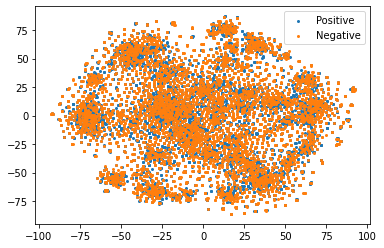

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


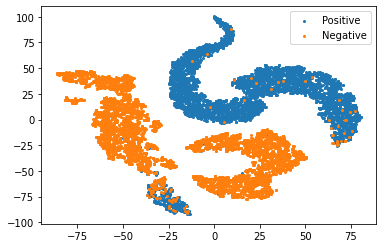

In [92]:
######################################## ROC Curve plot ###############################################

def ROC_dnn():
    plt.figure(figsize=(3,2),dpi=300)
    
    plt.plot(dnn_fpr.values,dnn_tpr.values)
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')        
    
    plt.title("ROC Curve for DNN")
    plt.show()     

def ROC_dnn_xgb(): # Enter ROC_dnn_xgb() in console to see the roc-auc plot for XGB Classifier
    plt.figure(figsize=(3,2),dpi=300)
    plt.plot(xgb_fpr.values,xgb_tpr.values)   
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')           
    plt.title("ROC Curve for DNN_XGB Classifier")
    plt.show()
    

######################################## TSNE plot ###############################################

def TSNE_raw():
    global raw_data
    # raw_data= pd.concat([df_pos,df_neg])
    # raw_data=raw_data.iloc[:,:-1]
    raw_data = np.hstack([seq_tensor[seq_index1], seq_tensor[seq_index2]])
    t=TSNE(n_components=2).fit_transform(raw_data)
    pos_t=t[:int(len(t)/2),:]
    neg_t=t[int(len(t)/2):,:]
    plt.scatter(pos_t[:,0],pos_t[:,1],label="Positive",s=4)
    plt.scatter(neg_t[:,0],neg_t[:,1],label="Negative",s=4)
    plt.legend()
    plt.show()

TSNE_raw()

def TSNE_extracted():
    
    pos=extracted_df[extracted_df.iloc[:,-1]==1]
    neg=extracted_df[extracted_df.iloc[:,-1]==0]
    X_feat=pd.concat([pos,neg])
    X_feat=X_feat.iloc[:,:-1]
    t=TSNE(n_components=2).fit_transform(X_feat)
    pos_t=t[:int(len(t)/2),:]
    neg_t=t[int(len(t)/2):,:]
    plt.scatter(pos_t[:,0],pos_t[:,1],label="Positive",s=4)
    plt.scatter(neg_t[:,0],neg_t[:,1],label="Negative",s=4)
    plt.legend()
    plt.show()

TSNE_extracted()